<a href="https://colab.research.google.com/github/caalr11/FisicaComputacional1/blob/master/Evaluacion1/Evaluacion1_CarlosArias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EVALUACION 1

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [38]:
url ='https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt'
col= ['site_code','year','month','day','hour','minute','second','time_decimal','CO2','value_std_dev','nvalue','latitude','longitude','altitude','elevation','intake_height','qcflag']
df_ca1=pd.read_csv(url, names=col, encoding='cp1251', sep='\s+', header=None, skiprows=151, engine='python')

#Reemplazar los -999.99 en Value por NaN

the9=-999.99
df_ca2=df_ca1.replace(to_replace=the9, value=np.nan, regex=True)
#df_ca2.head()
#Construir columna fecha, combinando año,mes y dia.
df_ca3=df_ca2.copy()
df_ca3['Fecha']= df_ca3['year'].astype(str)+"-"+ df_ca3['month'].astype(str)+"-"+ df_ca3['day'].astype(str)
df_ca3['Fecha']=pd.to_datetime(df_ca3['Fecha'],dayfirst=True)
#df_ca3.head()

#Construir dataframe
df_80=df_ca3[(df_ca3['year']>=1980)&(df_ca3['year']<2019)]

#convertir dataframe con tiempo
ts_test=df_80.copy()
ts_test=ts_test.set_index('Fecha')
#test.head()

#Eliminar todas las otras columnas y dejar fecha y value

ts_test=ts_test.drop(['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag'],axis=1)
#ts_test.head()

#Rellenar
ts_test.ffill(axis=0,inplace=True)
ts_test.head()

,CO2
Fecha,
1980-01-01,336.30
1980-01-02,336.28
1980-01-03,336.21
1980-01-04,336.19
1980-01-05,336.20


Parte 2

In [40]:
#Probar estacionalidad
def test_stationarity(df_ts):
  rolmean = df_ts.rolling(window=365, center=True).mean()
  rolstd = df_ts.rolling(window=365, center=True).std()
  plt.rcParams["figure.figsize"] = (12,6)
  plt.plot(df_ts, color='blue',label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
  plt.legend(loc='best')
  plt.title('Promedio Móvil y Desviación Estándar')
  plt.grid()
  plt.show()
  print('Resultados de la Prueba de Dickey-Fuller:')
  dftest = adfuller(df_ts, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)


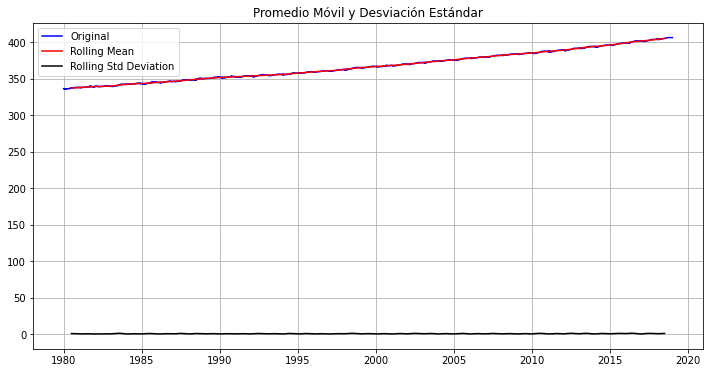

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     1.040077
p-value                            0.994671
#Lags Used                        42.000000
Number of Observations Used    14202.000000
Critical Value (1%)               -3.430811
Critical Value (5%)               -2.861744
Critical Value (10%)              -2.566878
dtype: float64


In [41]:
start, end = '1980-01', '2019-12'
ts_test = ts_test.loc[start:end].copy()
ts_test = ts_test['CO2'].copy()
test_stationarity(ts_test)

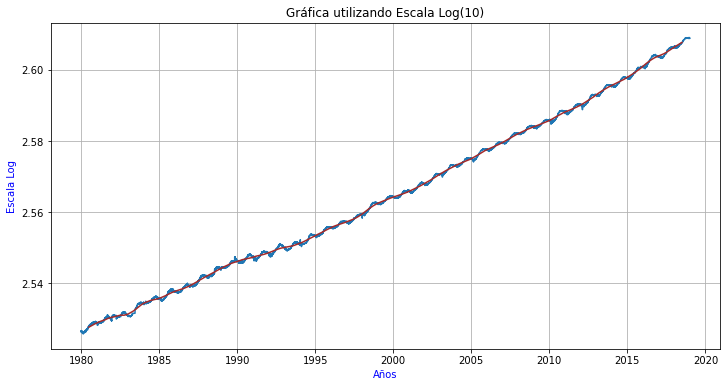

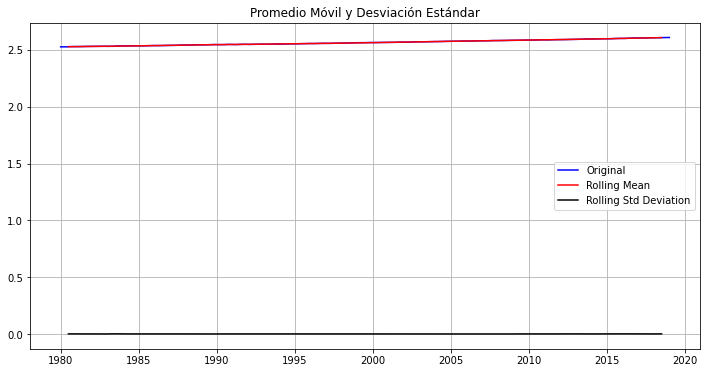

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     0.596300
p-value                            0.987524
#Lags Used                        42.000000
Number of Observations Used    14202.000000
Critical Value (1%)               -3.430811
Critical Value (5%)               -2.861744
Critical Value (10%)              -2.566878
dtype: float64


In [42]:
#p>0.05 Por lo tanto no es estacionaria, se transformara.

ts_test_log = np.log10(ts_test)
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

test_stationarity(ts_test_log)


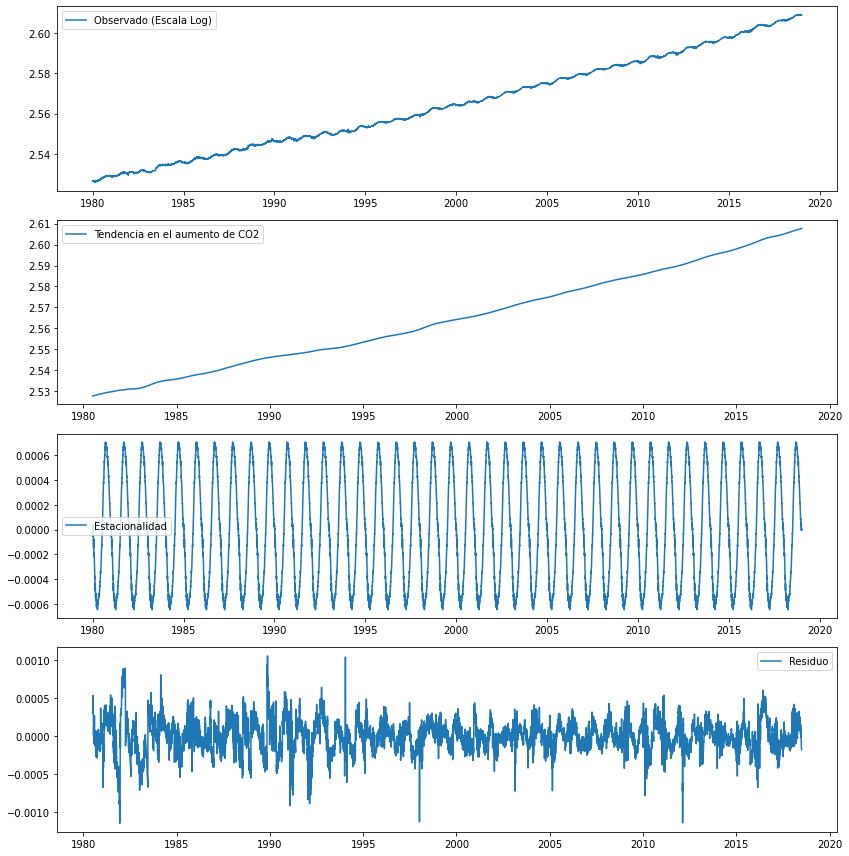

In [43]:
#p sigue siendo mayor que 0.05
#descomposicion
decompfreq = 365 
des = sm.tsa.seasonal_decompose(ts_test_log.interpolate(),
                                    freq=decompfreq, model='additive')
trend = des.trend
seasonal = des.seasonal
residue = des.resid
#Graficas
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia en el aumento de CO2')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')
plt.tight_layout();

Tendencia: Se observa que el CO2 esta subiendo en linea recta practicamnete año con año.

Estacionalidad: No se puede notar bien.

Residuo: La desviación de los datos va reduciendose año tras año.

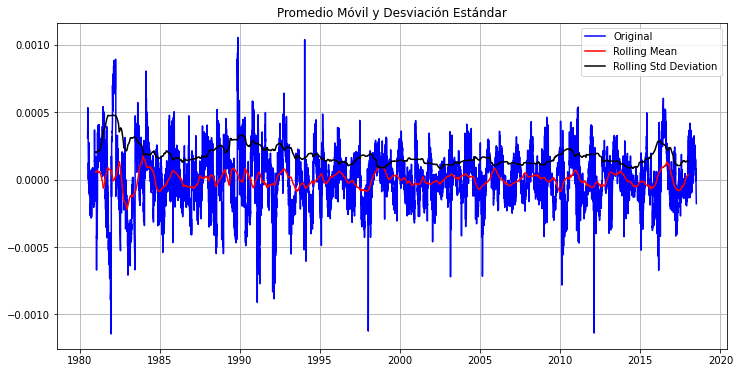

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.114891e+01
p-value                        2.977546e-20
#Lags Used                     3.000000e+01
Number of Observations Used    1.385000e+04
Critical Value (1%)           -3.430822e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [44]:
#Estacionalidad del residuo
ts_test_log_des = residue
ts_test_log_des.dropna(inplace=True)
test_stationarity(ts_test_log_des)


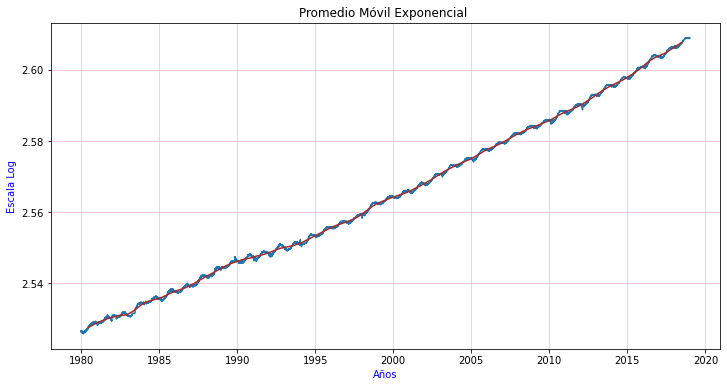

In [45]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid(color= 'pink')
plt.show();

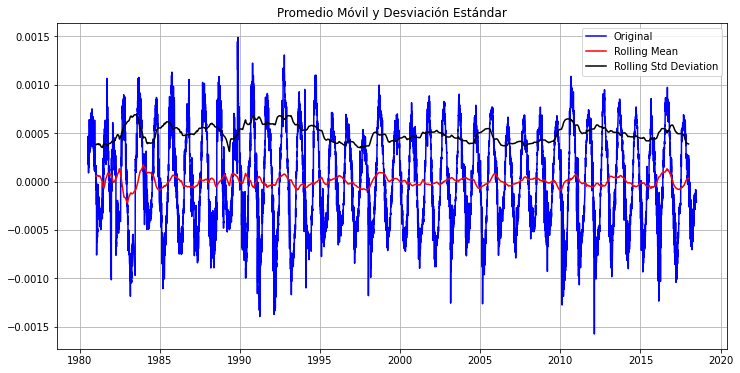

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.117304e+01
p-value                        2.611637e-20
#Lags Used                     4.200000e+01
Number of Observations Used    1.383800e+04
Critical Value (1%)           -3.430823e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [46]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.dropna(inplace=True)
test_stationarity(ts_test1_log_moving_ave_diff)

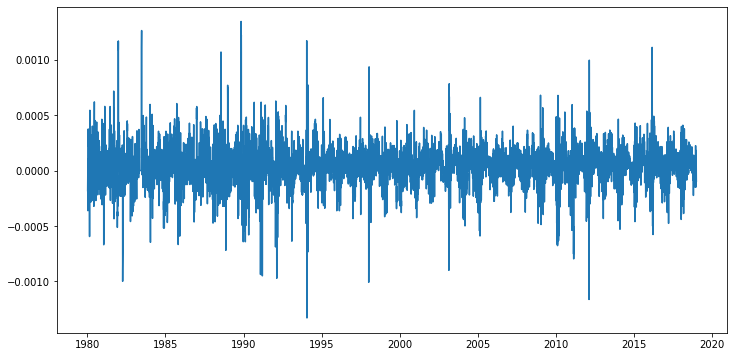

In [47]:
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
ts_test_log_diff.dropna(inplace=True)
plt.plot(ts_test_log_diff);

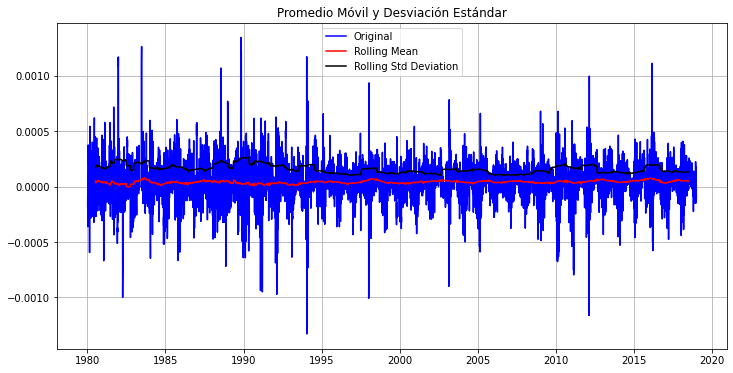

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.164723e+01
p-value                        2.078172e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.419500e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [48]:
test_stationarity(ts_test_log_diff)

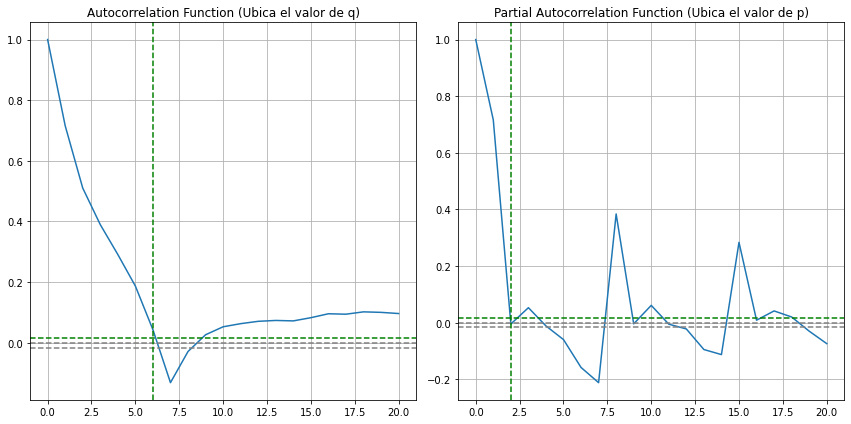

In [49]:
#ARIMA
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')
plt.rcParams["figure.figsize"] = (12,6)
# ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
#lineas verticales de referencia
plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')
#PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')
plt.tight_layout()

la p=2  y la q=7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14244
Model:                 ARIMA(2, 1, 0)   Log Likelihood              113194.841
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -226381.683
Time:                        05:44:57   BIC                        -226351.426
Sample:                    01-02-1980   HQIC                       -226371.619
                         - 12-31-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.766e-06   5.39e-07     10.706      0.000    4.71e-06    6.82e-06
ar.L1.D.CO2    -0.1568      0.008    -19.010      0.000      -0.173      -0.141
ar.L2.D.CO2    -0.1750      0.008    -21.208    

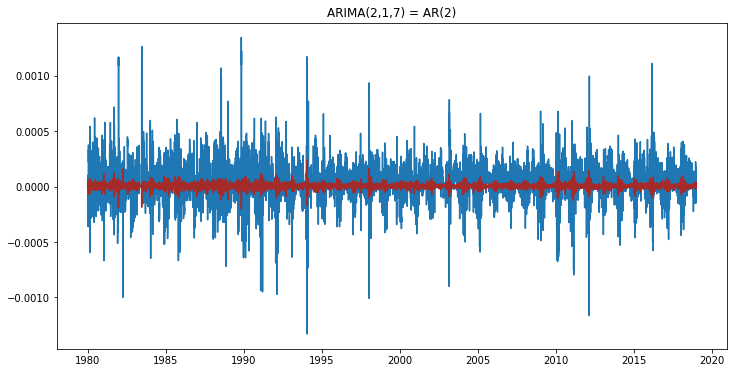

In [50]:
#(p,d,q) = (2,1,7) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,7) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14244
Model:                 ARIMA(0, 1, 7)   Log Likelihood              113305.737
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -226593.474
Time:                        05:45:17   BIC                        -226525.397
Sample:                    01-02-1980   HQIC                       -226570.830
                         - 12-31-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.766e-06   4.33e-07     13.319      0.000    4.92e-06    6.61e-06
ma.L1.D.CO2    -0.1909      0.008    -22.810      0.000      -0.207      -0.174
ma.L2.D.CO2    -0.1740      0.009    -20.318    

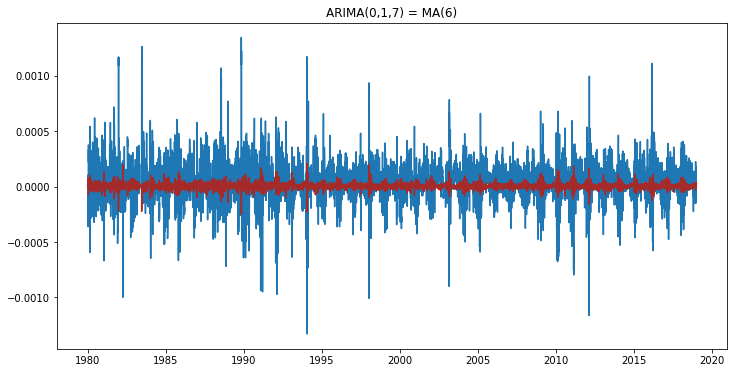

In [51]:
#(p,d,q) = (2,1,7) 
model = ARIMA(ts_test_log, order=(0,1,7), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,7) = MA(6)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14244
Model:                 ARIMA(2, 1, 7)   Log Likelihood              113306.684
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -226591.369
Time:                        05:45:45   BIC                        -226508.164
Sample:                    01-02-1980   HQIC                       -226563.692
                         - 12-31-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.769e-06   4.35e-07     13.261      0.000    4.92e-06    6.62e-06
ar.L1.D.CO2     0.3948      0.237      1.665      0.096      -0.070       0.860
ar.L2.D.CO2    -0.5286      0.202     -2.621    

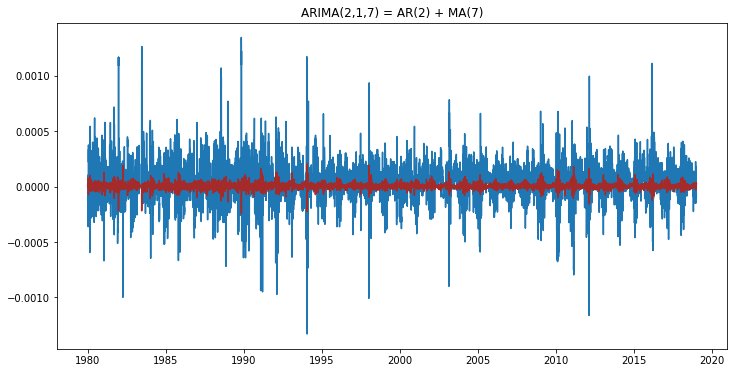

In [52]:

# (p,d,q) = (2,1,7) 
model = ARIMA(ts_test_log, order=(2,1,7), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,7) = AR(2) + MA(7)')
print(results_ARIMA.summary())

El mejor AIC es el tercero, es el mas corto.

Fecha
1980-01-02    0.000006
1980-01-03    0.000010
1980-01-04    0.000026
1980-01-05    0.000032
1980-01-06    0.000023
                ...   
2018-12-27   -0.000007
2018-12-28   -0.000004
2018-12-29    0.000005
2018-12-30    0.000036
2018-12-31    0.000026
Length: 14244, dtype: float64
Fecha
1980-01-01         NaN
1980-01-02    2.526707
1980-01-03    2.526621
1980-01-04    2.526611
1980-01-05    2.526630
dtype: float64
RMSE: 0.019009275720534007


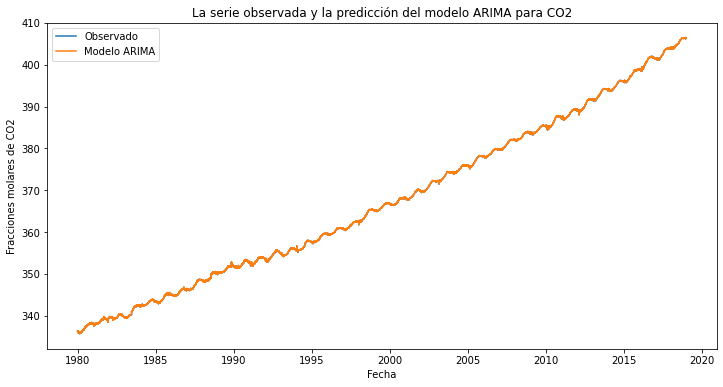

In [54]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())

predictions_ARIMA = 10**(predictions_ARIMA_log)

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test1, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Fracciones molares de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para CO2')
plt.legend(loc='best');

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test1)**2))
print('RMSE:', RMSE)


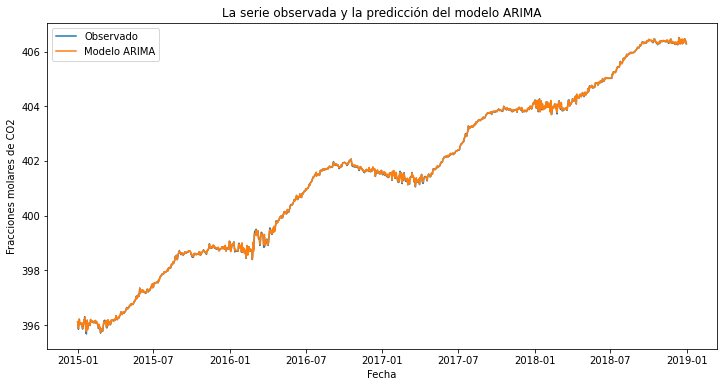

In [55]:
start, end = '2015-01', '2019-12'
ts_test_last = ts_test.loc[start:end].copy()
predictions_ARIMA_last = predictions_ARIMA.loc[start:end].copy()


plt.plot(ts_test_last, label='Observado');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Fracciones molares de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');